FastText by Facebook Research has improved performance for word embeddings and text classification tasks on many datasets. It is efficient to use.

In [23]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

from sklearn.decomposition import PCA

import wikipedia

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shutt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shutt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shutt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Scraping Wikipedia Articles.  Alternatively for files, Apache Tika is wonderful to use to read text from a variety of file formats.  OCR is supported when paired with Google's Tesseract.

In [8]:
systems_engineering = wikipedia.page("Systems Engineering").content
risk_assessment = wikipedia.page("Risk assessment").content
engineering = wikipedia.page("Engineering").content
risk_management = wikipedia.page("Risk Management").content
reliability_engineering = wikipedia.page("Reliability Engineering").content
asset_integrity_management_systems = wikipedia.page("Asset integrity management systems").content

systems_engineering = sent_tokenize(systems_engineering)
risk_assessment = sent_tokenize(risk_assessment)
risk_management = sent_tokenize(risk_management)
reliability_engineering = sent_tokenize(reliability_engineering)
asset_integrity_management_systems = sent_tokenize(asset_integrity_management_systems)

systems_engineering.extend(risk_assessment)
systems_engineering.extend(risk_management)
systems_engineering.extend(reliability_engineering)
systems_engineering.extend(asset_integrity_management_systems)

In [9]:
stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [12]:
final_corpus = [preprocess_text(sentence) for sentence in systems_engineering if sentence.strip() !='']
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]

Creating Words Representation
We have preprocessed our corpus. Now is the time to create word representations using FastText. Let's first define the hyper-parameters for our FastText model.

Here embedding_size is the size of the embedding vector. In other words, each word in our corpus will be represented as a 50-dimensional vector. The window_size is the size of the number of words occurring before and after the word based on which the word representations will be learned for the word. This might sound tricky, however in the skip-gram model we input a word to the algorithm and the output is the context words. If the window size is 40, for each input there will be 80 outputs: 40 words that occur before the input word and 40 words that occur after the input word. The word embeddings for the input word are learned using these 80 output words.

The next hyper-parameter is the min_word, which specifies the minimum frequency of a word in the corpus for which the word representations will be generated. Finally, the most frequently occurring word will be down-sampled by a number specified by the down_sampling attribute.

In [13]:
embedding_size = 50
window_size = 40
min_word = 5
down_sampling = 1e-2

In [16]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      word_ngrams = 3,
                      iter=100)

Wall time: 17.2 s


Let's now see the word representation for the word "systems". To do so, you can use the wv method of the FastText object and pass it the name of the word inside a list.

In [17]:
print(ft_model.wv['systems'])

[ 0.13597806  0.09220635 -0.06222356  0.0316073  -0.23960795  0.17280874
 -0.19428445 -0.09530488  0.49346817  0.1960188   0.0713393   0.16190825
  0.1970005  -0.0259989   0.07899886 -0.00771668 -0.1038752  -0.1048083
  0.02103007 -0.04357452  0.35945314  0.18676926  0.2525946   0.00829234
 -0.10823803  0.01195557  0.17996547 -0.04393115 -0.10754419  0.09186142
  0.15509038 -0.09414651 -0.24743828 -0.36458617  0.17319365 -0.11750047
  0.38403282  0.18678793 -0.07452524 -0.02033769  0.10380575 -0.1377826
 -0.13280673 -0.07125853 -0.10289924  0.02281556 -0.20210987  0.05290314
  0.00501809 -0.18288088]


In the output above, you can see a 50-dimensional vector for the word "systems"

Let's now find top 5 most similar words for the words 'systems', 'engineering', 'risk', 'reliability', 'safety'.  You can chose any number of words. The following script prints the specified words along with the 5 most similar words.

In [18]:
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['systems', 'engineering', 'risk', 'reliability', 'safety']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

systems:['systematic', 'system', 'human', 'engineering', 'iterative']
engineering:['system', 'course', 'reliability', 'seen', 'design']
risk:['assessment', 'management', 'reduction', 'assessed', 'mitigation']
reliability:['failure', 'availability', 'maintainability', 'maintenance', 'system']
safety:['health', 'critical', 'injury', 'environmental', 'accident']


We can also find the cosine similarity between the vectors for any two words, as shown below:

In [19]:
print(ft_model.wv.similarity(w1='risk', w2='reliability'))

0.12159649


Visualizing word similarities

In [21]:
all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

['systems', 'systematic', 'system', 'human', 'engineering', 'iterative', 'engineering', 'system', 'course', 'reliability', 'seen', 'design', 'risk', 'assessment', 'management', 'reduction', 'assessed', 'mitigation', 'reliability', 'failure', 'availability', 'maintainability', 'maintenance', 'system', 'safety', 'health', 'critical', 'injury', 'environmental', 'accident']
<class 'list'>
30


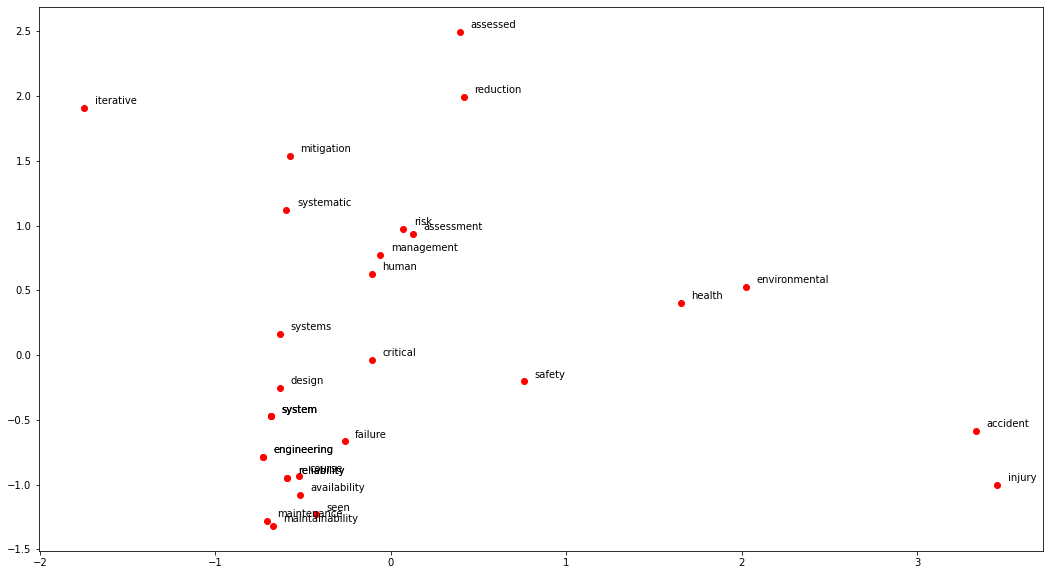

In [22]:
word_vectors = ft_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')